In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer, AerSimulator

In [2]:
def nXOR(qc, qubits, output):
    for q in qubits:
        qc.cx(q, output)
    qc.barrier()

def XOR1(qc, a, output):
    qc.cx(a, output)
    qc.barrier()

def get_phase_gate(n):
    size = 2**n
    i = -np.eye(size)
    i[0][0] = 1
    phase_gate = UnitaryGate(i)
    return phase_gate

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for q in range(n):
        qc.h(q)
    qc.append(get_phase_gate(n), range(n))
    for q in range(n):
        qc.h(q)
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

In [4]:
def generate_clause_list(A, n):
    clause_list = []
    
    for i in range(n):
        l = []
        for j in range(n):
            if A.item((i, j)) == 1:
                l.append(j)
        clause_list.append(l)
    
    return clause_list

In [5]:
def lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list):
    
    qc.barrier()
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.mcx(eq_qubits, sol_qubit)
    
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.barrier()
    
    qc.append(diffuser(n), range(n))
    

In [6]:
def lights_out_solver(A, p, n, t, init_distribution):
    var_qubits = QuantumRegister(n, name='click')
    p_qubits = QuantumRegister(n, name='initial')
    eq_qubits = QuantumRegister(n, name='output')  
    sol_qubit = QuantumRegister(1, name='solution')
    c_bits = ClassicalRegister(n, name='classical')
    
    clause_list = generate_clause_list(A, n)
    qc = QuantumCircuit(var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits)
    
    # INITIALIZATION
    # - STATE on SOLUTION QUBIT
    qc.x(sol_qubit)
    qc.h(sol_qubit)
    
    # Initial state to solve
    for i in range(n):
        if p[i] == 1:
            qc.x(p_qubits[i])
    
    
    # SUPERPOSITION OF BITSTRING WITH INITIAL DISTRIBUTION
    qc.initialize(init_distribution, var_qubits)
    
    for i in range(t):
        lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list)
    
    for i in range(n):
        qc.measure(var_qubits[i], c_bits[i])
    
    return qc

In [7]:
A = np.matrix([[1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 0, 1, 1]])
print(A)

[[1 1 1 0 0 0 0 0]
 [1 1 1 1 0 1 1 1]
 [1 1 1 0 1 1 0 0]
 [0 1 0 1 0 0 1 1]
 [0 0 1 0 1 1 1 0]
 [0 1 1 0 1 1 0 0]
 [0 1 0 1 1 0 1 1]
 [0 1 0 1 0 0 1 1]]


In [8]:
G = nx.Graph(A - np.eye(A.shape[0]))

In [9]:
print("RANK : ", np.linalg.matrix_rank(A))

RANK :  7


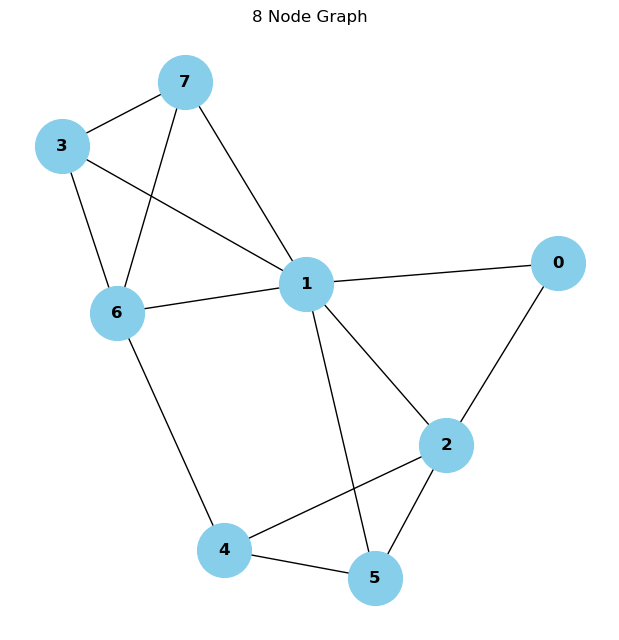

In [10]:
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.title("8 Node Graph")
plt.show()

Normalization factor (deno): 5.365993878688499
List of probabilities: [0.18635876644801722, 0.09317938322400861, 0.06211958881600573, 0.046589691612004304, 0.03727175328960344, 0.031059794408002866, 0.026622680921145316, 0.023294845806002152]
Sum of squared probabilities: 1.0000000000000002


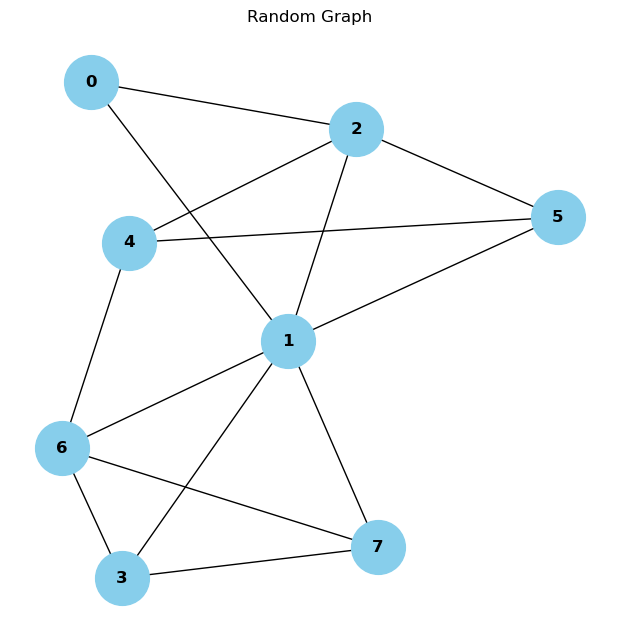

00000001 -> 1 -> 0.18635876644801722
00000010 -> 1 -> 0.18635876644801722
00000011 -> 2 -> 0.09317938322400861
00000100 -> 1 -> 0.18635876644801722
00000101 -> 2 -> 0.09317938322400861
00000110 -> 2 -> 0.09317938322400861
00000111 -> 3 -> 0.06211958881600573
00001000 -> 1 -> 0.18635876644801722
00001001 -> 2 -> 0.09317938322400861
00001010 -> 2 -> 0.09317938322400861
00001011 -> 3 -> 0.06211958881600573
00001100 -> 2 -> 0.09317938322400861
00001101 -> 3 -> 0.06211958881600573
00001110 -> 3 -> 0.06211958881600573
00001111 -> 4 -> 0.046589691612004304
00010000 -> 1 -> 0.18635876644801722
00010001 -> 2 -> 0.09317938322400861
00010010 -> 2 -> 0.09317938322400861
00010011 -> 3 -> 0.06211958881600573
00010100 -> 2 -> 0.09317938322400861
00010101 -> 3 -> 0.06211958881600573
00010110 -> 3 -> 0.06211958881600573
00010111 -> 4 -> 0.046589691612004304
00011000 -> 2 -> 0.09317938322400861
00011001 -> 3 -> 0.06211958881600573
00011010 -> 3 -> 0.06211958881600573
00011011 -> 4 -> 0.04658969161200430

In [11]:
n = 8

deno_sq = sum([(1 / (i+1))**2 * math.comb(n, i+1) for i in range(n)])
deno = math.sqrt(deno_sq)

p = []
for i in range(n):
    prob = 1 / ((i + 1) * deno)
    p.append(prob)

print("Normalization factor (deno):", deno)
print("List of probabilities:", p)

s = 0
for idx, i in enumerate(p):
    s += i**2 * float(math.comb(n, idx+1))
print("Sum of squared probabilities:", s)

def count_ones(bit_string):
    return bit_string.count('1')

def generate_bit_strings(n):
    bit_strings = []
    for i in range(2**n):
        bit_string = bin(i)[2:].zfill(n)
        bit_strings.append(bit_string)
    return bit_strings

def map_to_ones_count(bit_strings):
    ones_count_map = {}
    for bit_string in bit_strings:
        ones_count = count_ones(bit_string)
        if bit_string not in ones_count_map:
            ones_count_map[bit_string] = ones_count
    return ones_count_map

bit_strings = generate_bit_strings(n)
ones_count_map = map_to_ones_count(bit_strings)
prob_map = {"00000000": [0, 0]}
state = [0]
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.title("Random Graph")
plt.show()
for string, count in ones_count_map.items():
    if string != "00000000":
        state.append(p[count-1])
        prob_map[string] = []
        prob_map[string].append(p[count-1])
        prob_map[string].append(count_ones(string))
        print(f"{string} -> {count} -> {p[count-1]}")

s = 0
for i in state:
    s += i**2
print(len(state))

In [12]:
p = [1, 1, 1, 1, 1, 0, 0, 1]
qc = lights_out_solver(A, p, len(A), 3, state)

In [13]:
# qc.draw(filename=f"glo_8node_2sol.png")

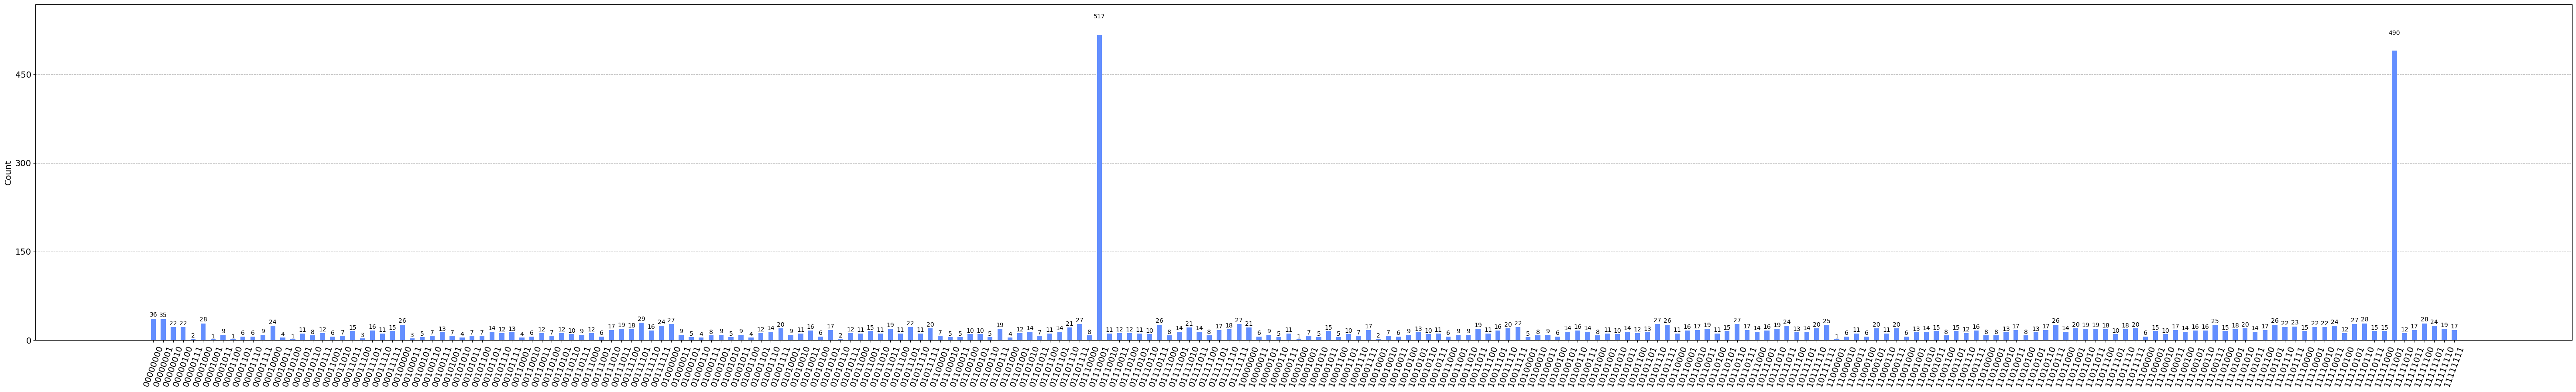

In [14]:
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc, shots=4096).result()
plot_histogram(result.get_counts(), figsize=(75, 10))

In [15]:
res = result.get_counts()
print(res['11111001'], res['01110001'])

490 517


### Exponentially reducing distribution

In [16]:
import numpy as np

def hamming_weight(vector):
    return sum(vector)

def calculate_probability(alpha, vector):
    return alpha ** hamming_weight(vector)

def normalize_probabilities(alpha, vectors):
    total_probability = sum(calculate_probability(alpha, vector) for vector in vectors)
    return [calculate_probability(alpha, vector) / total_probability for vector in vectors]

def generate_vectors(length):
    return [[int(b) for b in format(i, '0' + str(length) + 'b')] for i in range(2**length)]

def probs():
    alpha = math.exp(1)
    length = 8
    vectors = generate_vectors(length)
    probabilities = normalize_probabilities(alpha, vectors)
    probabilities = reversed(probabilities)

    s = 0
    mp = {}
    for vector, probability in zip(vectors, probabilities):
        # if hamming_weight(vector) == 0:
        #     print("Vector:", vector, "Probability:", 0, "Coefficient:", 0)    
        v = "".join([str(i) for i in vector])
        p = probability
        c = p**0.5
        mp[v] = c
        # print("Vector:", "".join([str(i) for i in vector]), "Probability:", probability, "Coefficient:", probability**0.5)
        s += probability
    print("SUM : ", s)
    print(mp["00000000"], mp["11111111"])
    return mp


In [17]:
mp = probs()

SUM :  1.0000000000000022
0.2856332167670458 0.005231554852932745


In [18]:
# for k, v in zip(mp.keys(), mp.values()):
#     print(k, v)

In [19]:
p = [1, 1, 1, 1, 1, 0, 0, 1]
init_dist = list(mp.values())

print(init_dist[:10], init_dist[-10:])

# p = init_dist[0]**2
sq_p = [i**2 for i in init_dist]

add_all = sq_p[0] / len(sq_p)
sq_p[0] = 0
sq_p = [i + add_all for i in sq_p]

init_dist = [i**0.5 for i in sq_p]

qc = lights_out_solver(A, p, len(A), 3, init_dist)

[0.2856332167670458, 0.17324530340155792, 0.17324530340155792, 0.10507858816426226, 0.17324530340155792, 0.10507858816426226, 0.10507858816426226, 0.0637333854009421, 0.17324530340155792, 0.10507858816426226] [0.014220840491313813, 0.008625375764864697, 0.023446202205262744, 0.014220840491313813, 0.014220840491313813, 0.008625375764864697, 0.014220840491313813, 0.008625375764864697, 0.008625375764864697, 0.005231554852932745]


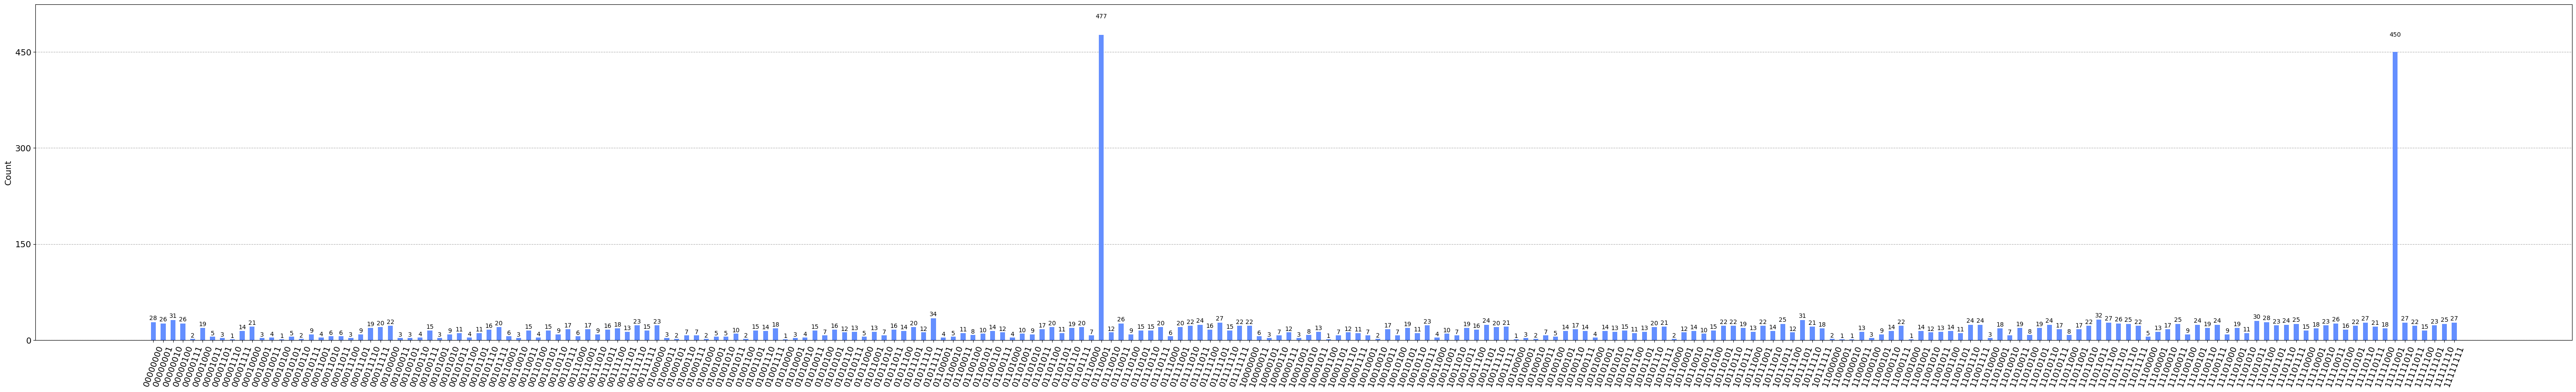

In [20]:
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc, shots=4096).result()
plot_histogram(result.get_counts(), figsize=(75, 10))

In [21]:
res = result.get_counts()
print(res['11111001'], res['01110001'])

450 477
